In [10]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, ConfusionMatrixDisplay

import modelmetrics

# In this chapter, we're using Logistic Regression 
It works by modeling the probability of a sentiment label positive,negative or neutra.
Overall,logistic regression is a simple yet effective algorithm for sentiment analysis that can be applied to a wide range of datasets and text data.

In [2]:
data = pd.read_csv('Data/dacy_sentiment.csv', lineterminator='\n')
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
data['sentiment'] = data['sentiment'].replace(sentiment_map)
data

,title,body,rating,sentiment,predicted,prob_pos,prob_neu,prob_neg
0,Der var service på i dag,"Der var service på i dag, det var dejligt. Så...",5,1,positive,0.999,0.001,0.001
1,Et af verdens ringeste kurér firmaer,Hvorfor i alverden man vælger at drive et verd...,2,-1,neutral,0.003,0.994,0.003
2,Rigtig god information om levering😃,Rigtig god information om levering😃,5,1,positive,0.927,0.072,0.001
3,Meget hjælpsom chauffør,Meget hjælpsom chauffør. Pakken kom til den af...,5,1,positive,0.981,0.017,0.003
4,Pakken kom fuldstændig som forventet.,Pakken kom fuldstændig som forventet.,3,0,neutral,0.023,0.964,0.014
...,...,...,...,...,...,...,...,...
595,"Undgå UPS, og undgå firmaer, der bruger UPS so...","En vare udebliver, men vi får regningen. Vi ri...",1,-1,negative,0.005,0.402,0.593
596,Uforståelig rundrejse...,Skulle få pakke sendt fra Bergen (Norge) med d...,1,-1,neutral,0.003,0.992,0.005
597,Virkelig god service -kan klart…,Virkelig god service -kan klart anbefale post ...,5,1,positive,0.999,0.000,0.001
598,God hurtig Service,God hurtig Service,5,1,positive,0.996,0.004,0.001


## Training and testing the model

In this process, we are training a logistic regression classifier on a dataset of customer reviews to predict the sentiment of new, previously unseen reviews.

First, we split the dataset into a training set and a test set using the sample() and drop() methods from pandas. Then, we create a CountVectorizer object to convert the text data into a bag-of-words representation, which counts the occurrence of each word in the text. We fit the vectorizer on the training set and use it to transform both the training and test sets into vectors of word counts.

Next, we train the LogisticRegression classifier on the training vectors and corresponding sentiment labels. We use the trained classifier to predict the sentiment of a new, previously unseen review by converting it into a vector using the same vectorizer, and then calling predict() on the classifier object.

Finally, we print the predicted sentiment, as well as the actual review (if it was predicted to be negative) and the counts of each sentiment label in the dataset.

Overall, this process demonstrates a basic workflow for sentiment analysis using a logistic regression classifier and bag-of-words representations.

In [3]:
train_data = data.sample(frac=0.8, random_state=42)
test_data = data.drop(train_data.index)

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', max_features=1000)
train_vectors = vectorizer.fit_transform(train_data['body'])
test_vectors = vectorizer.transform(test_data['body'])

clf = LogisticRegression(random_state=42)
clf.fit(train_vectors, train_data['sentiment'])

#new_review = data.loc[1, 'body']
new_review = "Bedste levering, super godt arbejde af postnord, lige til tiden"
new_review_vector = vectorizer.transform([new_review])
predicted_sentiment = clf.predict(new_review_vector)[0]

#Tjekker hvor mange af hver der
sentiment_counts = data['sentiment'].value_counts()
print(sentiment_counts)

if predicted_sentiment == 1:
    print("Positive sentiment")
elif predicted_sentiment == 0:
    print("Neutral sentiment")
else:
    print("Negative sentiment")
    #print("Actual: ", data.loc[1,'body'])

 1    362
-1    224
 0     14
Name: sentiment, dtype: int64
Positive sentiment


In [4]:
y_true = test_data['sentiment']
y_pred = clf.predict(test_vectors)
probs = clf.predict_proba(test_vectors)

report = classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive'])
print(report)

              precision    recall  f1-score   support

    Negative       1.00      0.88      0.94        42
     Neutral       0.00      0.00      0.00         1
    Positive       0.93      0.99      0.96        77

    accuracy                           0.94       120
   macro avg       0.64      0.62      0.63       120
weighted avg       0.94      0.94      0.94       120



In [5]:
log_loss_test = log_loss(y_true, probs)
log_loss_test

0.17409823830798288

In [ ]:
print('Accuracy:', accuracy_score(y_true, y_pred))
print('Precision:', precision_score(y_true, y_pred))
print('Recall:', recall_score(y_true, y_pred))
print('F1 Score:', f1_score(y_true, y_pred))

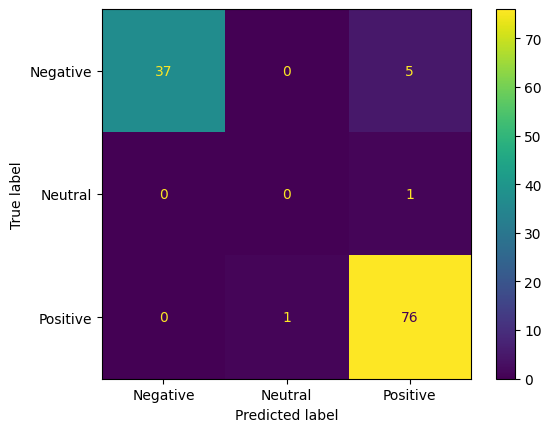

In [9]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=['Negative', 'Neutral', 'Positive'])

In [11]:
report = classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive'], output_dict=True)
report['log_loss'] = log_loss_test
modelmetrics.save_to_file('Data/metrics.csv', 'LogisticRegression', report)